In [4]:
import os
import csv
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing


class RegressionTemperatureScaling(nn.Module):
    def __init__(self, epsilon=1e-6):
        """
        Initialize the RegressionTemperatureScaling module.

        Args:
            epsilon (float): A small constant to ensure numerical stability.
        """
        super(RegressionTemperatureScaling, self).__init__()
        
        # Learnable parameter: raw temperature
        # Initialized to 1.0 to start with no scaling (variance remains unchanged)
        self.temperature_raw = nn.Parameter(torch.ones(1) * 1.0)
        
        # Small constant to avoid numerical issues (e.g., log(0) or division by zero)
        self.epsilon = epsilon

    @property
    def temperature(self):
        """
        Apply softplus transformation to ensure temperature > 0.
        Returns:
            torch.Tensor: The positive temperature value derived from raw temperature.
        """
        # Softplus ensures that the temperature is strictly positive
        # T = log(1 + exp(temperature_raw))
        return torch.log(1 + torch.exp(self.temperature_raw))

    def forward(self, variance):
        """
        Scale the variance by the temperature.
        
        Args:
            variance (torch.Tensor): Predicted variance from the model.
        
        Returns:
            torch.Tensor: Variance scaled by the learned temperature.
        """
        # Scale the input variance by dividing it by the temperature
        return variance / self.temperature

    def calibrate(self, predicted_mean, predicted_variance, y_true, lr=0.01, max_iter=50):
        """
        Calibrate the temperature parameter using predictions and true values.

        Args:
            predicted_mean (torch.Tensor): Predicted mean from the model.
            predicted_variance (torch.Tensor): Predicted variance from the model.
            y_true (torch.Tensor): Ground truth values from the calibration dataset.
            lr (float): Learning rate for optimization.
            max_iter (int): Maximum number of optimization iterations.
        """
        # Define the optimizer for the temperature_raw parameter
        optimizer = optim.LBFGS([self.temperature_raw], lr=0.01, max_iter=max_iter)
        
        # Expand avg_mean and avg_variance to match the size of y_calib
        predicted_mean = torch.full_like(y_calib, predicted_mean)  # Expand to tensor
        predicted_variance = torch.full_like(y_calib, predicted_variance)  # Expand to tensor

        # Detach the inputs to ensure the gradients don't flow to the PNN
        # Calibration adjusts only the temperature, not the PNN parameters
        predicted_mean = predicted_mean.detach()
        predicted_variance = predicted_variance.detach()
        y_true = y_true.detach()

        # Closure function for the LBFGS optimizer
        def closure():
            # Clear any previously computed gradients
            optimizer.zero_grad()
            
            # Scale the variance by the current temperature
            scaled_variance = torch.clamp(predicted_variance / self.temperature, min=self.epsilon)
            
            # Compute the Gaussian Negative Log-Likelihood loss
            loss = 0.5 * (
                torch.log(scaled_variance)
                + ((y_true - predicted_mean) ** 2) / scaled_variance
            ).mean()
            
            # Compute gradients for the temperature parameter
            loss.backward()
            return loss

        # Optimize the temperature parameter to minimize the loss
        optimizer.step(closure)

    def get_calibrated_variance(self, predicted_variance):
        """
        Get calibrated variance after applying temperature scaling.

        Args:
            predicted_variance (torch.Tensor): Predicted variance from the model.

        Returns:
            torch.Tensor: Variance scaled by the learned temperature.
        """
        # Scale the predicted variance by the learned temperature
        return self.forward(predicted_variance)
    
    
class RegressionPNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        """
        Initialize a generic Probabilistic Neural Network for regression.

        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Number of neurons in the hidden layer.
            output_dim (int): Number of output features (default: 1 for regression).
        """
        super(RegressionPNN, self).__init__()
        
        # Define the architecture
        self.hidden = nn.Linear(input_dim, hidden_dim)  # Hidden layer
        self.activation = nn.ReLU()  # Activation function
        self.mean = nn.Linear(hidden_dim, output_dim)  # Predict mean
        self.log_variance = nn.Linear(hidden_dim, output_dim)  # Predict log(variance)

    def forward(self, x):
        """
        Forward pass for the regression PNN.

        Args:
            x (torch.Tensor): Input data (shape: [batch_size, input_dim]).
        
        Returns:
            tuple: Predicted mean and variance (both shape: [batch_size, output_dim]).
        """
        # Hidden layer with activation
        h = self.activation(self.hidden(x))
        
        # Predict mean and log(variance)
        mean = self.mean(h)
        log_var = self.log_variance(h)
        
        # Return mean and variance (variance = exp(log(variance)))
        return mean, torch.exp(log_var)
    
def generate_sinusoidal_data(n_samples=1000, noise_level=4.0, sparsity_factor=0.1):
    """
    Generate synthetic data with both aleatoric and epistemic uncertainty.

    Args:
        n_samples (int): Total number of samples to generate.
        noise_level (float): Magnitude of aleatoric noise.
        sparsity_factor (float): Proportion of samples with high epistemic uncertainty.

    Returns:
        tuple: Input data (x), ground truth (y), and epistemic uncertainty mask.
    """
    # Generate x values uniformly in [-3, 3]
    x = np.random.uniform(-3, 3, size=(n_samples, 1))
    
    # Define the true function with some aleatoric noise
    # Sinusoidal Function
    y_clean = 2 * np.sin(3 * x + 4) + 5
    
    aleatoric_noise = noise_level * (1 + np.abs(x)) * np.random.normal(size=(n_samples, 1))
    y_noisy = y_clean + aleatoric_noise

    # Add epistemic uncertainty: Higher uncertainty in certain regions
    epistemic_mask = (np.abs(x) > 2)  # Regions where x > 2 or x < -2 are less sampled
    epistemic_uncertainty = sparsity_factor * (np.random.normal(size=(n_samples, 1)) * epistemic_mask)
    y_final = y_noisy + epistemic_uncertainty

    return torch.tensor(x, dtype=torch.float32), torch.tensor(y_final, dtype=torch.float32), epistemic_mask


def generate_ishigami_data(n_samples=1000, noise_level=4.0, sparsity_factor=0.1,  a=7.0, b=0.1):
    """
    Generate synthetic data with both aleatoric and epistemic uncertainty.

    Args:
        n_samples (int): Total number of samples to generate.
        noise_level (float): Magnitude of aleatoric noise.
        sparsity_factor (float): Proportion of samples with high epistemic uncertainty.

    Returns:
        tuple: Input data (x), ground truth (y), and epistemic uncertainty mask.
    """
    # Generate x values uniformly in [-3, 3]
    x = np.random.uniform(-3, 3, size=(n_samples, 1))
    
    # Define the true function with some aleatoric noise
    # "Ishigami" Function
    y_clean = np.sin(x) + a * np.sin(x) ** 2 + b * x ** 4 * np.sin(x)
    
    aleatoric_noise = noise_level * (1 + np.abs(x)) * np.random.normal(size=(n_samples, 1))
    y_noisy = y_clean + aleatoric_noise

    # Add epistemic uncertainty: Higher uncertainty in certain regions
    epistemic_mask = (np.abs(x) > 2)  # Regions where x > 2 or x < -2 are less sampled
    epistemic_uncertainty = sparsity_factor * (np.random.normal(size=(n_samples, 1)) * epistemic_mask)
    y_final = y_noisy + epistemic_uncertainty

    return torch.tensor(x, dtype=torch.float32), torch.tensor(y_final, dtype=torch.float32), epistemic_mask


def generate_multidimensional_ishigami_data(n_samples=1000, n_features=2, noise_level=4.0, sparsity_factor=0.1, a=7.0, b=0.1):
    """
    Generate synthetic multidimensional Ishigami data with aleatoric and epistemic uncertainty.

    Args:
        n_samples (int): Total number of samples to generate.
        n_features (int): Number of input features/dimensions.
        noise_level (float): Magnitude of aleatoric noise.
        sparsity_factor (float): Proportion of samples with high epistemic uncertainty.
        a (float): Parameter controlling nonlinearity in the Ishigami function.
        b (float): Parameter controlling interaction in the Ishigami function.

    Returns:
        tuple: Input data (X), ground truth (y), and epistemic uncertainty mask.
    """
    # Generate uniform input data for multiple dimensions in [-3, 3]
    X = np.random.uniform(-3, 3, size=(n_samples, n_features))
    
    # Initialize output as zeros
    y_clean = np.zeros(n_samples)
    
    # Apply the Ishigami function to each feature independently and add interactions
    for i in range(n_features):
        y_clean += np.sin(X[:, i]) + a * (np.sin(X[:, i]) ** 2) + b * (X[:, i] ** 4) * np.sin(X[:, i])
    
    # Add interaction terms between features
    if n_features > 1:
        for i in range(n_features - 1):
            for j in range(i + 1, n_features):
                y_clean += 0.1 * np.sin(X[:, i] * X[:, j])  # Interaction term
    
    # Add aleatoric noise
    aleatoric_noise = noise_level * (1 + np.abs(X).sum(axis=1, keepdims=True)) * np.random.normal(size=(n_samples, 1)).flatten()
    y_noisy = y_clean + aleatoric_noise

    # Add epistemic uncertainty: Higher uncertainty in certain regions
    epistemic_mask = (np.abs(X).sum(axis=1) > 2 * n_features)  # High uncertainty for large input magnitudes
    epistemic_uncertainty = sparsity_factor * np.random.normal(size=n_samples) * epistemic_mask
    y_final = y_noisy + epistemic_uncertainty

    return (
        torch.tensor(X, dtype=torch.float32), 
        torch.tensor(y_final, dtype=torch.float32), 
        torch.tensor(epistemic_mask, dtype=torch.bool)
    )



def process_real_world_dataset(test_size=0.15, calib_size=0.15):
    """
    Load, preprocess, and split the California Housing dataset.

    Args:
        test_size (float): Proportion of the data to use as the test set.
        calib_size (float): Proportion of the data to use as the calibration set.

    Returns:
        tuple: Training, calibration, and test splits for features and targets.
    """
    # Load the dataset
    data = fetch_california_housing()
    X = data.data
    y = data.target

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the dataset into train, calibration, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(test_size + calib_size), random_state=42)
    calib_split = calib_size / (test_size + calib_size)
    X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=calib_split, random_state=42)

    # Convert to PyTorch tensors
    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_calib, dtype=torch.float32),
        torch.tensor(y_calib, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32)
    )


def generate_dataset(dataset_type, n_samples=1000, noise_level=4.0, sparsity_factor=0.1, a=7.0, b=0.1, n_features=1):
    """
    Generate data for the specified dataset type.

    Args:
        dataset_type (str): Type of dataset ("sinusoidal", "ishigami", "cubic", "california_housing").
        n_samples (int): Number of samples to generate (only for synthetic datasets).
        noise_level (float): Noise level for synthetic data.
        sparsity_factor (float): Sparsity factor for epistemic uncertainty in synthetic data.
        a (float): Parameter for the Ishigami function.
        b (float): Parameter for the Ishigami function.
        n_features (int): Number of input features for Ishigami data (default: 1).

    Returns:
        tuple: Training, calibration, and test splits for features and targets.
    """
    if dataset_type == "sinusoidal":
        return generate_sinusoidal_data(n_samples, noise_level, sparsity_factor)
    elif dataset_type == "ishigami":
        if n_features == 1:
            return generate_ishigami_data(n_samples, noise_level, sparsity_factor, a, b)
        else:
            return generate_multidimensional_ishigami_data(
                n_samples=n_samples, n_features=n_features, noise_level=noise_level, sparsity_factor=sparsity_factor, a=a, b=b
            )
    elif dataset_type == "california_housing":
        return process_real_world_dataset()
    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")

        
def calculate_coverage(mean, variance, targets, T=1.0, z=1.96):
    lower_bound = mean - z * torch.sqrt(variance / T)
    upper_bound = mean + z * torch.sqrt(variance / T)
    in_interval = ((targets >= lower_bound) & (targets <= upper_bound)).float()
    return in_interval.mean().item(), in_interval.numpy()





--- Evaluating on Sinusoidal (1D) Dataset ---
Experiment 1/100
Experiment 2/100
Experiment 3/100
Experiment 4/100
Experiment 5/100
Experiment 6/100
Experiment 7/100
Experiment 8/100
Experiment 9/100
Experiment 10/100
Experiment 11/100
Experiment 12/100
Experiment 13/100
Experiment 14/100
Experiment 15/100
Experiment 16/100
Experiment 17/100
Experiment 18/100
Experiment 19/100
Experiment 20/100
Experiment 21/100
Experiment 22/100
Experiment 23/100
Experiment 24/100
Experiment 25/100
Experiment 26/100
Experiment 27/100
Experiment 28/100
Experiment 29/100
Experiment 30/100
Experiment 31/100
Experiment 32/100
Experiment 33/100
Experiment 34/100
Experiment 35/100
Experiment 36/100
Experiment 37/100
Experiment 38/100
Experiment 39/100
Experiment 40/100
Experiment 41/100
Experiment 42/100
Experiment 43/100
Experiment 44/100
Experiment 45/100
Experiment 46/100
Experiment 47/100
Experiment 48/100
Experiment 49/100
Experiment 50/100
Experiment 51/100
Experiment 52/100
Experiment 53/100
Experime

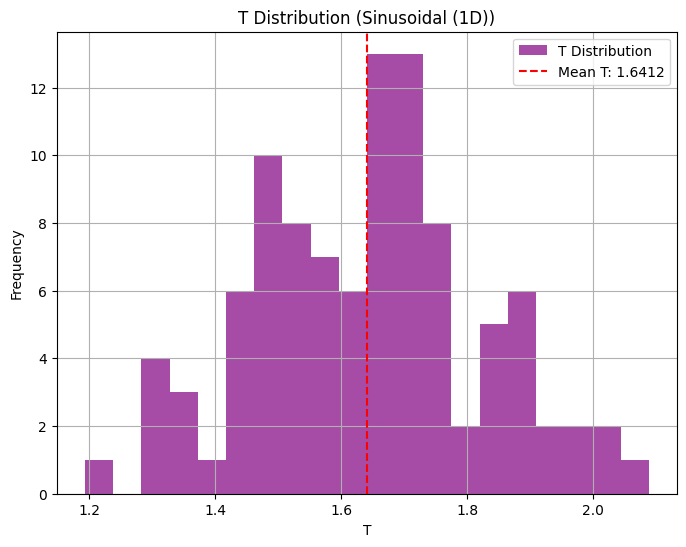

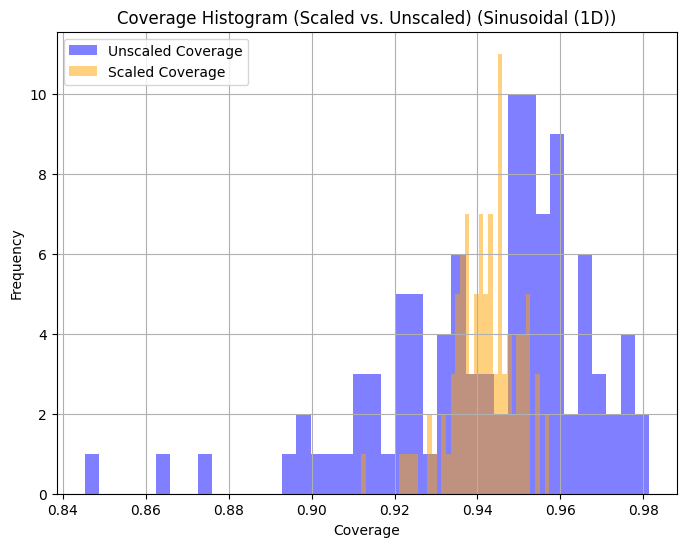

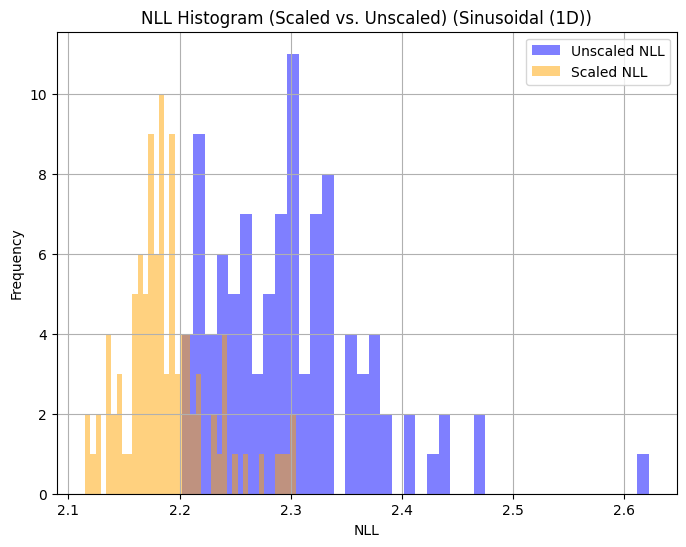

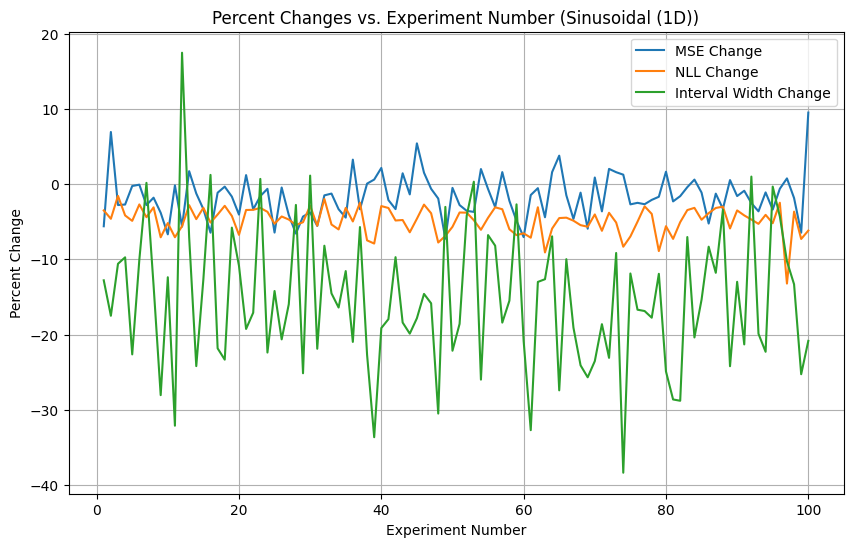

Execution Time for Sinusoidal (1D): 24.42 seconds (0.41 minutes)

--- Evaluating on Ishigami (1D) Dataset ---
Experiment 1/100
Experiment 2/100
Experiment 3/100
Experiment 4/100
Experiment 5/100
Experiment 6/100
Experiment 7/100
Experiment 8/100
Experiment 9/100
Experiment 10/100
Experiment 11/100
Experiment 12/100
Experiment 13/100
Experiment 14/100
Experiment 15/100
Experiment 16/100
Experiment 17/100
Experiment 18/100
Experiment 19/100
Experiment 20/100
Experiment 21/100
Experiment 22/100
Experiment 23/100
Experiment 24/100
Experiment 25/100
Experiment 26/100
Experiment 27/100
Experiment 28/100
Experiment 29/100
Experiment 30/100
Experiment 31/100
Experiment 32/100
Experiment 33/100
Experiment 34/100
Experiment 35/100
Experiment 36/100
Experiment 37/100
Experiment 38/100
Experiment 39/100
Experiment 40/100
Experiment 41/100
Experiment 42/100
Experiment 43/100
Experiment 44/100
Experiment 45/100
Experiment 46/100
Experiment 47/100
Experiment 48/100
Experiment 49/100
Experiment 50/100

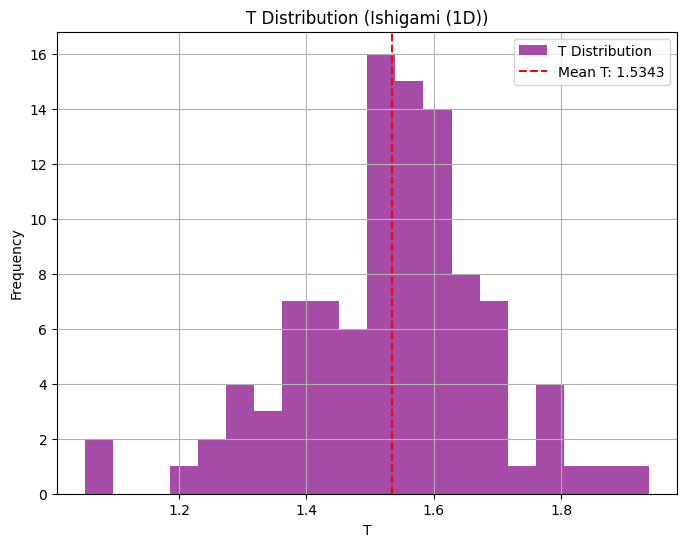

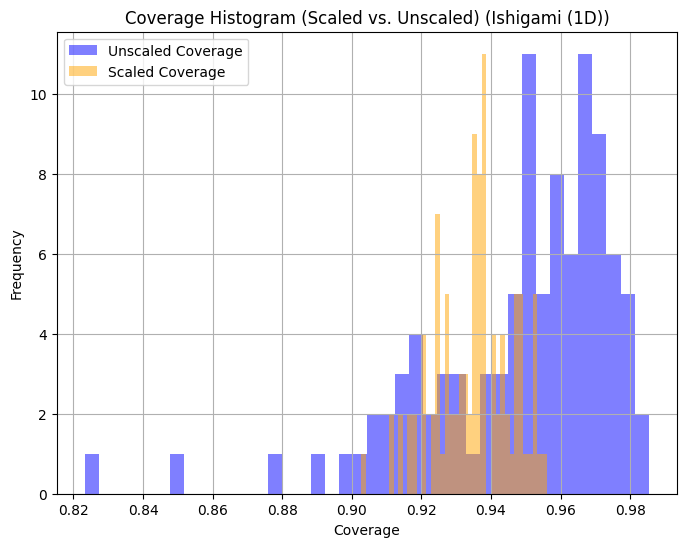

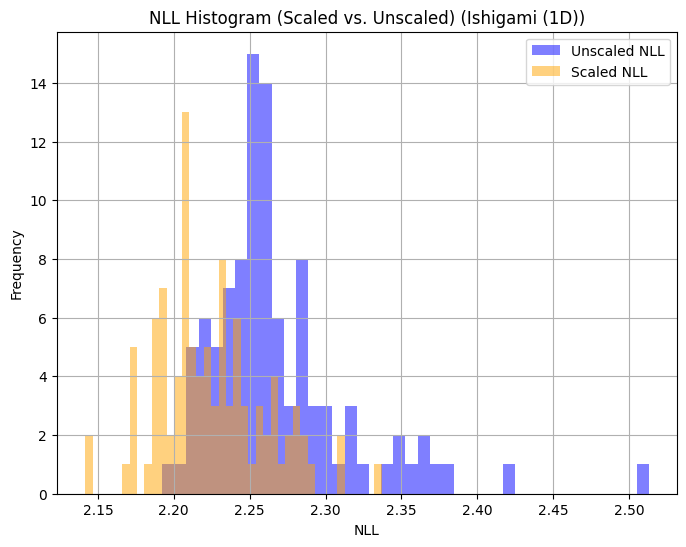

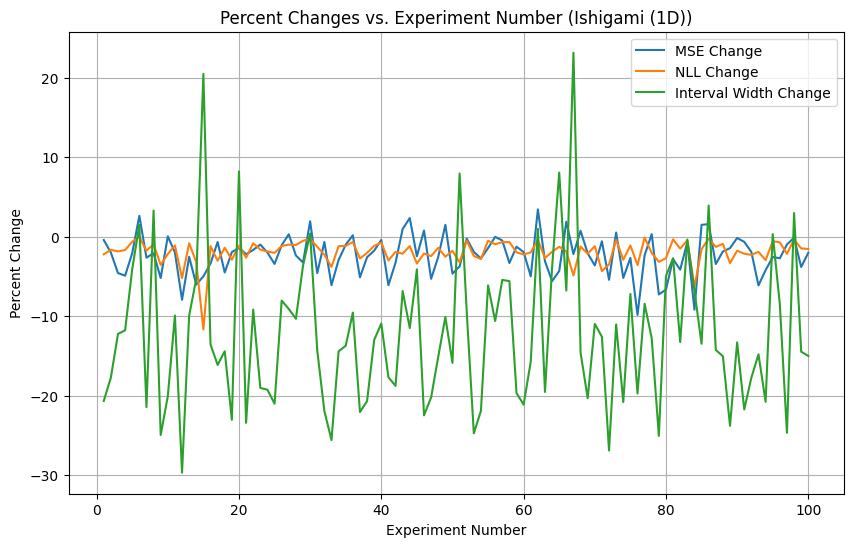

Execution Time for Ishigami (1D): 23.50 seconds (0.39 minutes)

--- Evaluating on Ishigami (3D) Dataset ---
Experiment 1/100
Experiment 2/100
Experiment 3/100
Experiment 4/100
Experiment 5/100
Experiment 6/100
Experiment 7/100
Experiment 8/100
Experiment 9/100
Experiment 10/100
Experiment 11/100
Experiment 12/100
Experiment 13/100
Experiment 14/100
Experiment 15/100
Experiment 16/100
Experiment 17/100
Experiment 18/100
Experiment 19/100
Experiment 20/100
Experiment 21/100
Experiment 22/100
Experiment 23/100
Experiment 24/100
Experiment 25/100
Experiment 26/100
Experiment 27/100
Experiment 28/100
Experiment 29/100
Experiment 30/100
Experiment 31/100
Experiment 32/100
Experiment 33/100
Experiment 34/100
Experiment 35/100
Experiment 36/100
Experiment 37/100
Experiment 38/100
Experiment 39/100
Experiment 40/100
Experiment 41/100
Experiment 42/100
Experiment 43/100
Experiment 44/100
Experiment 45/100
Experiment 46/100
Experiment 47/100
Experiment 48/100
Experiment 49/100
Experiment 50/100
E

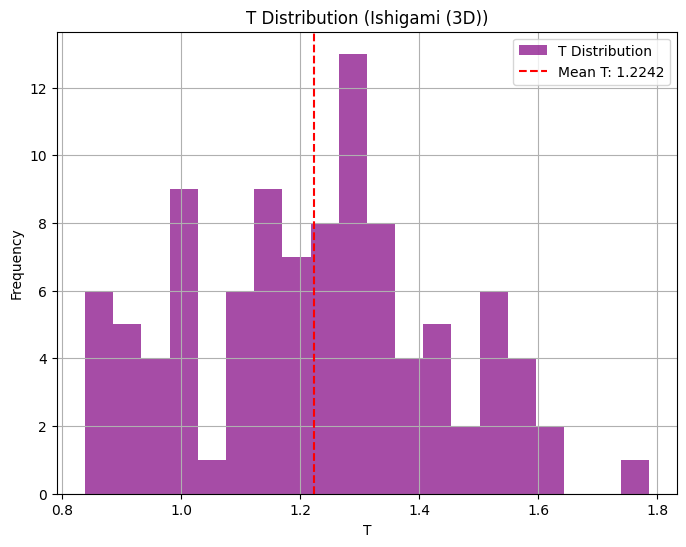

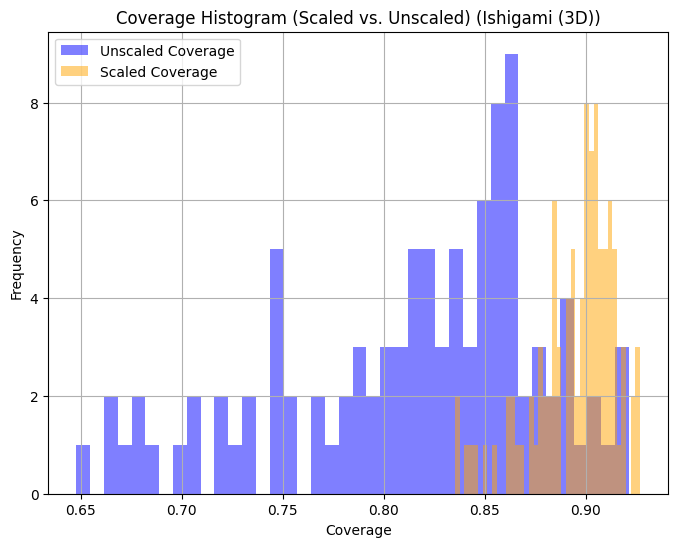

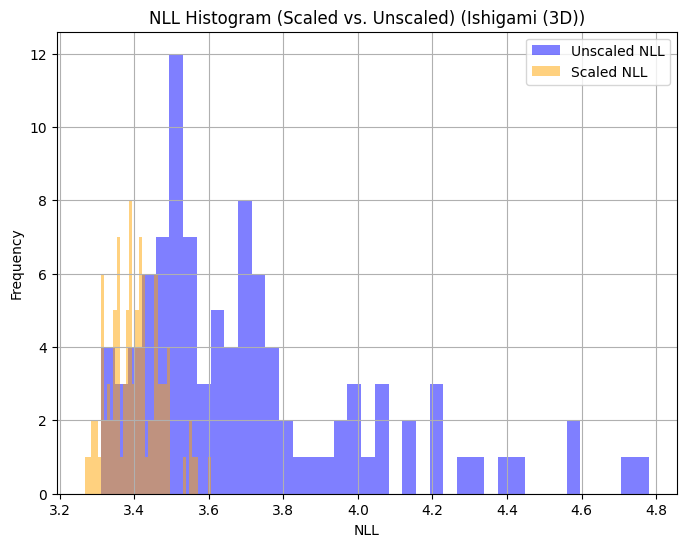

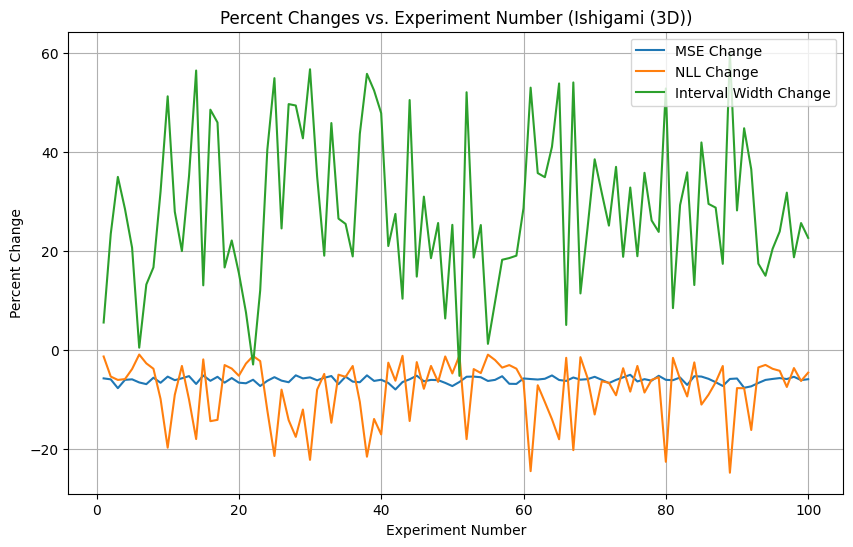

Execution Time for Ishigami (3D): 7127.68 seconds (118.79 minutes)

--- Evaluating on California_housing (8D) Dataset ---
Experiment 1/100
Experiment 2/100
Experiment 3/100
Experiment 4/100
Experiment 5/100
Experiment 6/100
Experiment 7/100
Experiment 8/100
Experiment 9/100
Experiment 10/100
Experiment 11/100
Experiment 12/100
Experiment 13/100
Experiment 14/100
Experiment 15/100
Experiment 16/100
Experiment 17/100
Experiment 18/100
Experiment 19/100
Experiment 20/100
Experiment 21/100
Experiment 22/100
Experiment 23/100
Experiment 24/100
Experiment 25/100
Experiment 26/100
Experiment 27/100
Experiment 28/100
Experiment 29/100
Experiment 30/100
Experiment 31/100
Experiment 32/100
Experiment 33/100
Experiment 34/100
Experiment 35/100
Experiment 36/100
Experiment 37/100
Experiment 38/100
Experiment 39/100
Experiment 40/100
Experiment 41/100
Experiment 42/100
Experiment 43/100
Experiment 44/100
Experiment 45/100
Experiment 46/100
Experiment 47/100
Experiment 48/100
Experiment 49/100
Exper

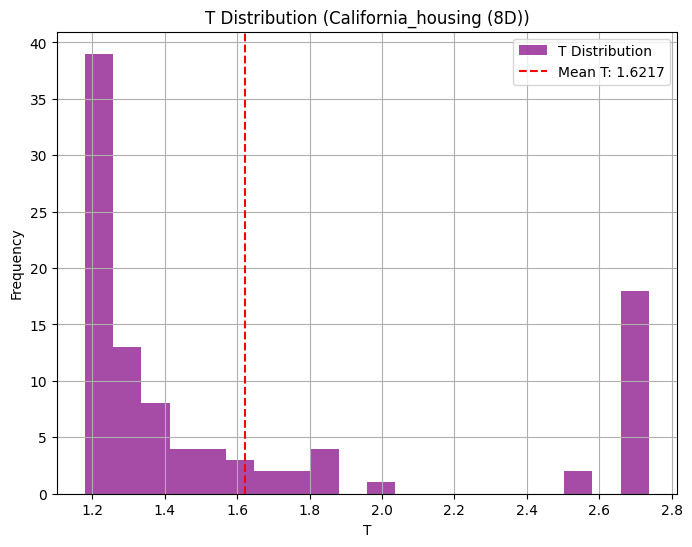

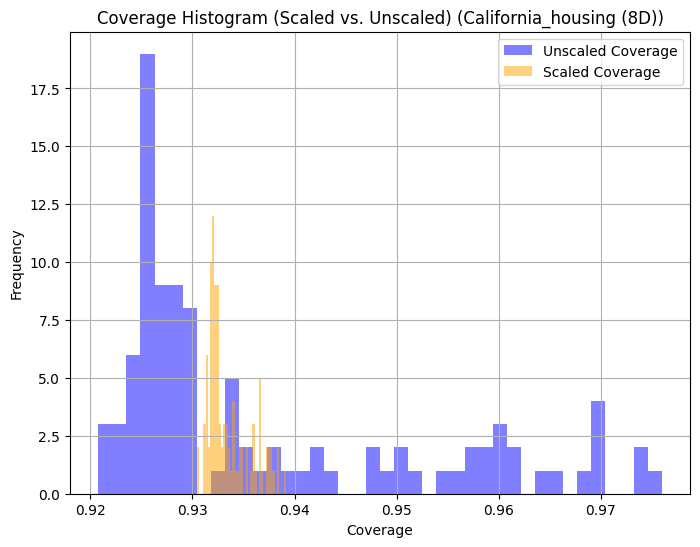

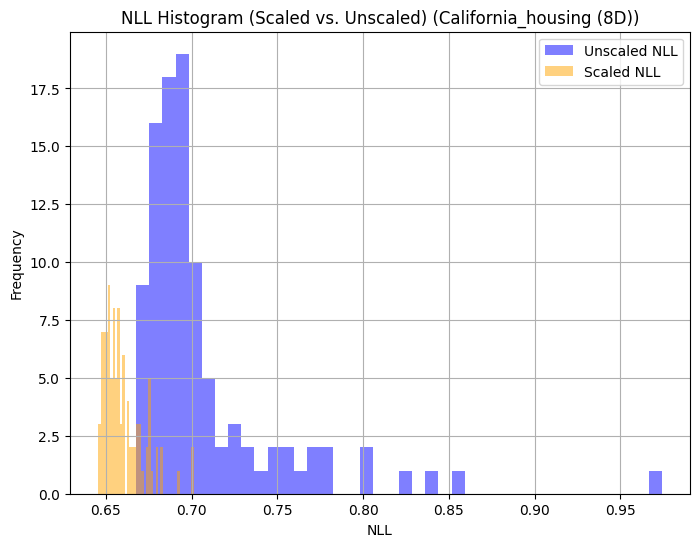

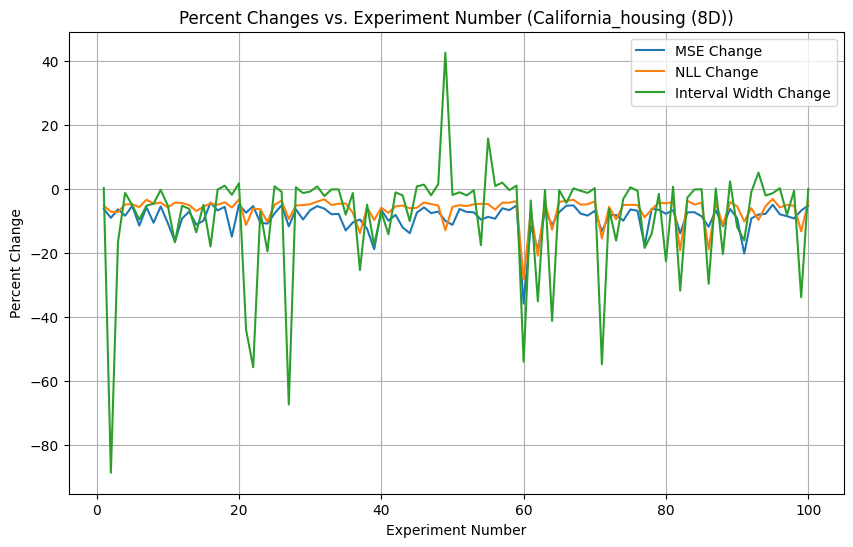

Execution Time for California_housing (8D): 19687.60 seconds (328.13 minutes)

Total Execution Time: 26863.21 seconds (447.72 minutes)


In [6]:
# Create a directory to save plots if it doesn't exist
plot_dir = "reg_pnn_temp_plots_TEST"
os.makedirs(plot_dir, exist_ok=True)

# Define the number of experiments
num_experiments = 100

# File to store results
csv_file = "reg_temp_experiment_TEST.csv"

# Create or overwrite the CSV file
with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Experiment", "Dataset", "T", "MSE Change", "NLL Unscaled", "NLL Scaled",
                     "NLL Change", "Interval Width Change", "Coverage Unscaled", "Coverage Scaled",
                     "Interval Width Unscaled", "Interval Width Scaled"])

# Start timing before the loop
start_time = time.time()    
    
# Iterate through each dataset type and experiment
for dataset_type, n_features in [("sinusoidal", 1), ("ishigami", 1), ("ishigami", 3), ("california_housing", 8)]:
    dataset_label = f"{dataset_type.capitalize()} ({n_features}D)"
    print(f"\n--- Evaluating on {dataset_label} Dataset ---")
    
    
    dataset_start_time = time.time()  # Start time for the dataset
    
    # Lists to store metrics for histograms and plots
    T_values = []
    NLL_unscaled_all = []
    NLL_scaled_all = []
    coverage_unscaled_all = []
    coverage_scaled_all = []
    mse_unscaled_all = []
    mse_scaled_all = []
    interval_width_unscaled_all = []
    interval_width_scaled_all = []
    mse_changes = []
    nll_changes = []
    interval_width_changes = []

    for experiment in range(1, num_experiments + 1):
        print(f"Experiment {experiment}/{num_experiments}")

        # 1. Generate data
        n_samples = 10000
        
        if dataset_type == "california_housing":
            # Load and preprocess the real-world dataset
            x_train, y_train, x_calib, y_calib, x_test, y_test = generate_dataset(dataset_type)
        else:
            # For synthetic datasets, unpack the data normally
            x, y, epistemic_mask = generate_dataset(
                dataset_type, n_samples=n_samples, noise_level=2.0, sparsity_factor=0.5, n_features=n_features
            )
            train_size, calib_size = int(0.7 * n_samples), int(0.15 * n_samples)
            x_train, y_train = x[:train_size], y[:train_size]
            x_calib, y_calib = x[train_size:train_size + calib_size], y[train_size:train_size + calib_size]
            x_test, y_test = x[train_size + calib_size:], y[train_size + calib_size:]

        # 2. Train the model using nn.GaussianNLLLoss
        model = RegressionPNN(input_dim=n_features, hidden_dim=32, output_dim=1)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.GaussianNLLLoss()

        for epoch in range(50):
            model.train()
            optimizer.zero_grad()
            mean, variance = model(x_train)
            loss = criterion(mean, y_train, variance)
            loss.backward()
            optimizer.step()
            

        # Evaluate on test data (Stage 1)
        model.eval()
        with torch.no_grad():
            mean_test, variance_test = model(x_test)
            
        mse_unscaled = ((y_test - mean_test) ** 2).mean().item()
        nll_unscaled = criterion(mean_test, y_test, variance_test).item()
        interval_width_unscaled = (1.96 * torch.sqrt(variance_test)).mean().item()
        coverage_unscaled, _ = calculate_coverage(mean_test, variance_test, y_test)

        # Append metrics
        mse_unscaled_all.append(mse_unscaled)
        NLL_unscaled_all.append(nll_unscaled)
        interval_width_unscaled_all.append(interval_width_unscaled)
        coverage_unscaled_all.append(coverage_unscaled)

        # 3. Calibrate T
        reg_temp_scaling = RegressionTemperatureScaling()
        reg_temp_scaling.calibrate(mean_test.mean().item(), variance_test.mean().item(), y_calib)
        learned_temperature = reg_temp_scaling.temperature.item()
        T_values.append(learned_temperature)

        # 4. Retrain the model using T-GaussianNLLLoss
        def t_gaussian_nll_loss(mean, target, variance):
            scaled_variance = variance / learned_temperature
            return nn.GaussianNLLLoss()(mean, target, scaled_variance)

        for epoch in range(50):
            model.train()
            optimizer.zero_grad()
            mean, variance = model(x_train)
            loss = t_gaussian_nll_loss(mean, y_train, variance)
            loss.backward()
            optimizer.step()

        # Evaluate on test data (Stage 2)
        model.eval()
        with torch.no_grad():
            mean_test_scaled, variance_test_scaled = model(x_test)
        
        mse_scaled = ((y_test - mean_test_scaled) ** 2).mean().item()
        nll_scaled = t_gaussian_nll_loss(mean_test_scaled, y_test, variance_test_scaled).item()
        interval_width_scaled = (1.96 * torch.sqrt(variance_test_scaled / learned_temperature)).mean().item()
        coverage_scaled, _ = calculate_coverage(mean_test_scaled, variance_test_scaled, y_test, T=learned_temperature)

        # Append metrics
        mse_scaled_all.append(mse_scaled)
        NLL_scaled_all.append(nll_scaled)
        interval_width_scaled_all.append(interval_width_scaled)
        coverage_scaled_all.append(coverage_scaled)

        # Calculate percentage changes
        percent_change_mse = ((mse_scaled - mse_unscaled) / mse_unscaled) * 100
        percent_change_nll = ((nll_scaled - nll_unscaled) / nll_unscaled) * 100
        percent_change_interval_width = ((interval_width_scaled - interval_width_unscaled) / interval_width_unscaled) * 100

        # Append percent changes for plotting
        mse_changes.append(percent_change_mse)
        nll_changes.append(percent_change_nll)
        interval_width_changes.append(percent_change_interval_width)

        # Store results in the CSV file
        with open(csv_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([
                experiment, dataset_label, learned_temperature, 
                percent_change_mse, nll_unscaled, nll_scaled, percent_change_nll, 
                percent_change_interval_width, coverage_unscaled, coverage_scaled, 
                interval_width_unscaled, interval_width_scaled
            ])

    # Calculate and print averages
    avg_mse_unscaled = sum(mse_unscaled_all) / len(mse_unscaled_all)
    avg_mse_scaled = sum(mse_scaled_all) / len(mse_scaled_all)
    avg_nll_unscaled = sum(NLL_unscaled_all) / len(NLL_unscaled_all)
    avg_nll_scaled = sum(NLL_scaled_all) / len(NLL_scaled_all)
    avg_interval_width_unscaled = sum(interval_width_unscaled_all) / len(interval_width_unscaled_all)
    avg_interval_width_scaled = sum(interval_width_scaled_all) / len(interval_width_scaled_all)

    print(f"\n--- Averages for {dataset_label} Dataset ---")
    print(f"Average MSE (Unscaled): {avg_mse_unscaled:.4f}")
    print(f"Average MSE (Scaled): {avg_mse_scaled:.4f}")
    print(f"Average NLL (Unscaled): {avg_nll_unscaled:.4f}")
    print(f"Average NLL (Scaled): {avg_nll_scaled:.4f}")
    print(f"Average Interval Width (Unscaled): {avg_interval_width_unscaled:.4f}")
    print(f"Average Interval Width (Scaled): {avg_interval_width_scaled:.4f}")
    
    # Calculate average percent changes
    avg_percent_change_mse = sum(mse_changes) / len(mse_changes)
    avg_percent_change_nll = sum(nll_changes) / len(nll_changes)
    avg_percent_change_interval_width = sum(interval_width_changes) / len(interval_width_changes)

    # Print the averages
    print(f"\n--- Average Percent Changes for {dataset_label} Dataset ---")
    print(f"Average Percent Change in MSE: {avg_percent_change_mse:.2f}%")
    print(f"Average Percent Change in NLL: {avg_percent_change_nll:.2f}%")
    print(f"Average Percent Change in Prediction Interval Width: {avg_percent_change_interval_width:.2f}%")
    
    avg_T = sum(T_values) / len(T_values)
    
    # Print the average learned T
    print(f"\n--- Averge Learned T for {dataset_label} Dataset ---")
    print(f"Average T: {avg_T}")

    # Plot histograms for T values
    plt.figure(figsize=(8, 6))
    plt.hist(T_values, bins=20, alpha=0.7, color="purple", label="T Distribution")
    plt.axvline(np.mean(T_values), color="r", linestyle="--", label=f"Mean T: {np.mean(T_values):.4f}")
    plt.xlabel("T")
    plt.ylabel("Frequency")
    plt.title(f"T Distribution ({dataset_label})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(plot_dir, f"T_Distribution_{dataset_label.replace(' ', '_')}.png"))
    plt.show()

    # Plot histograms for coverage (scaled vs. unscaled)
    plt.figure(figsize=(8, 6))
    plt.hist(coverage_unscaled_all, bins=40, alpha=0.5, label="Unscaled Coverage", color="blue")
    plt.hist(coverage_scaled_all, bins=40, alpha=0.5, label="Scaled Coverage", color="orange")
    plt.xlabel("Coverage")
    plt.ylabel("Frequency")
    plt.title(f"Coverage Histogram (Scaled vs. Unscaled) ({dataset_label})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(plot_dir, f"Coverage_Histogram_{dataset_label.replace(' ', '_')}.png"))
    plt.show()

    # Plot histograms for NLL (scaled vs. unscaled)
    plt.figure(figsize=(8, 6))
    plt.hist(NLL_unscaled_all, bins=40, alpha=0.5, label="Unscaled NLL", color="blue")
    plt.hist(NLL_scaled_all, bins=40, alpha=0.5, label="Scaled NLL", color="orange")
    plt.xlabel("NLL")
    plt.ylabel("Frequency")
    plt.title(f"NLL Histogram (Scaled vs. Unscaled) ({dataset_label})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(plot_dir, f"NLL_Histogram_{dataset_label.replace(' ', '_')}.png"))
    plt.show()

    # Plot percent changes vs. experiment number
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_experiments + 1), mse_changes, label="MSE Change")
    plt.plot(range(1, num_experiments + 1), nll_changes, label="NLL Change")
    plt.plot(range(1, num_experiments + 1), interval_width_changes, label="Interval Width Change")
    plt.xlabel("Experiment Number")
    plt.ylabel("Percent Change")
    plt.title(f"Percent Changes vs. Experiment Number ({dataset_label})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(plot_dir, f"Percent_Changes_{dataset_label.replace(' ', '_')}.png"))
    plt.show()
    
    dataset_end_time = time.time()  # End time for the dataset
    dataset_elapsed_time = dataset_end_time - dataset_start_time
    print(f"Execution Time for {dataset_label}: {dataset_elapsed_time:.2f} seconds ({dataset_elapsed_time/60:.2f} minutes)")

    
# End timing after the loop
end_time = time.time()

# Compute and print the elapsed time
elapsed_time = end_time - start_time
print(f"\nTotal Execution Time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")


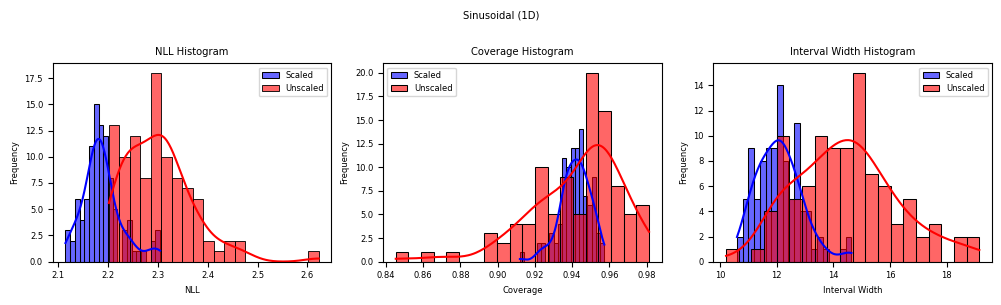

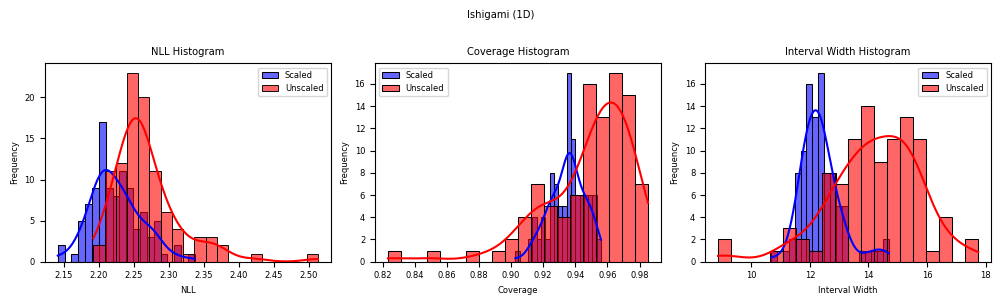

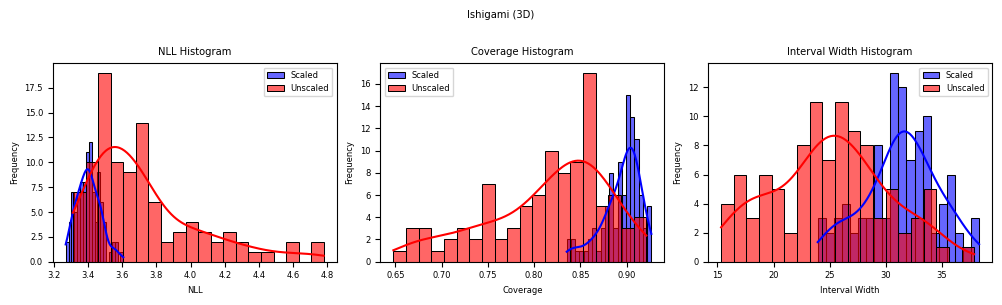

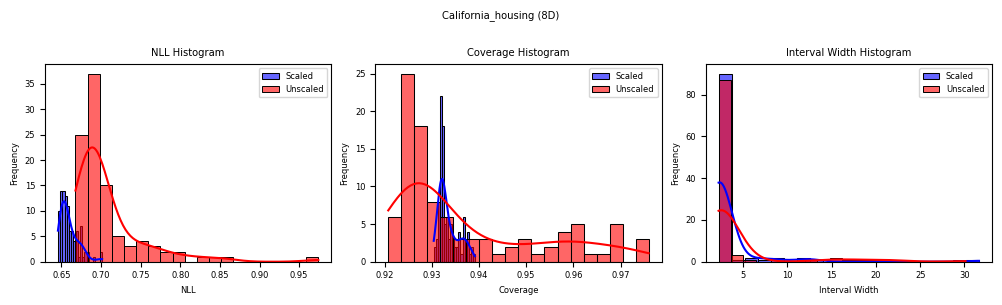

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plot_dir = "reg_pnn_temp_plots_TEST"
os.makedirs(plot_dir, exist_ok=True)

plt.rcParams.update({'font.size': 6, "figure.figsize": (10,3)})

# Load the dataset
file_path = "reg_temp_experiment_TEST.csv"
data = pd.read_csv(file_path)

# Extract unique datasets
datasets = data["Dataset"].unique()

# Initialize a plot for each dataset
for dataset in datasets:
    # Filter data for the specific dataset
    dataset_data = data[data["Dataset"] == dataset]
    
    # Create a figure for subplots
    fig, axes = plt.subplots(1, 3)
    fig.suptitle(f"{dataset}")

    # Plot NLL histogram
    sns.histplot(
        dataset_data["NLL Scaled"], bins=20, kde=True, color="blue", alpha=0.6, label="Scaled", ax=axes[0]
    )
    sns.histplot(
        dataset_data["NLL Unscaled"], bins=20, kde=True, color="red", alpha=0.6, label="Unscaled", ax=axes[0]
    )
    axes[0].set_title("NLL Histogram")
    axes[0].set_xlabel("NLL")
    axes[0].set_ylabel("Frequency")
    axes[0].legend()

    # Plot Coverage histogram
    sns.histplot(
        dataset_data["Coverage Scaled"], bins=20, kde=True, color="blue", alpha=0.6, label="Scaled", ax=axes[1]
    )
    sns.histplot(
        dataset_data["Coverage Unscaled"], bins=20, kde=True, color="red", alpha=0.6, label="Unscaled", ax=axes[1]
    )
    axes[1].set_title("Coverage Histogram")
    axes[1].set_xlabel("Coverage")
    axes[1].set_ylabel("Frequency")
    axes[1].legend()

    # Plot Interval Width histogram
    sns.histplot(
        dataset_data["Interval Width Scaled"], bins=20, kde=True, color="blue", alpha=0.6, label="Scaled", ax=axes[2]
    )
    sns.histplot(
        dataset_data["Interval Width Unscaled"], bins=20, kde=True, color="red", alpha=0.6, label="Unscaled", ax=axes[2]
    )
    axes[2].set_title("Interval Width Histogram")
    axes[2].set_xlabel("Interval Width")
    axes[2].set_ylabel("Frequency")
    axes[2].legend()

    # Adjust layout and show plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the figure to the specified directory
    output_path = os.path.join(plot_dir, f"{dataset.replace(' ', '_')}_beta_histograms.png")
    plt.savefig(output_path, dpi=300)
    
    plt.show()



In [7]:
# Compute averages for each metric, excluding the "Experiment" column
average_metrics = data.drop(columns=["Experiment"]).groupby("Dataset").mean()

# Print the results
print("\n=== Average Metrics Over All Trials ===\n")
print(average_metrics)



=== Average Metrics Over All Trials ===

                                T  MSE Change  NLL Unscaled  NLL Scaled  \
Dataset                                                                   
California_housing (8D)  1.621690   -9.017886      0.707895    0.659654   
Ishigami (1D)            1.534317   -2.357507      2.268554    2.224457   
Ishigami (3D)            1.224189   -6.140259      3.721107    3.402943   
Sinusoidal (1D)          1.641242   -1.664835      2.301226    2.188303   

                         NLL Change  Interval Width Change  Coverage Unscaled  \
Dataset                                                                         
California_housing (8D)   -6.556020              -8.778347           0.937348   
Ishigami (1D)             -1.922603             -12.113323           0.947927   
Ishigami (3D)             -8.033675              28.484950           0.814961   
Sinusoidal (1D)           -4.863275             -15.386592           0.942193   

                    